In [55]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import qr
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit, RawFeatureVector
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

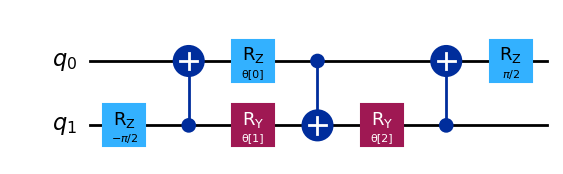

In [56]:
# We now define a two qubit unitary as defined in [3]

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

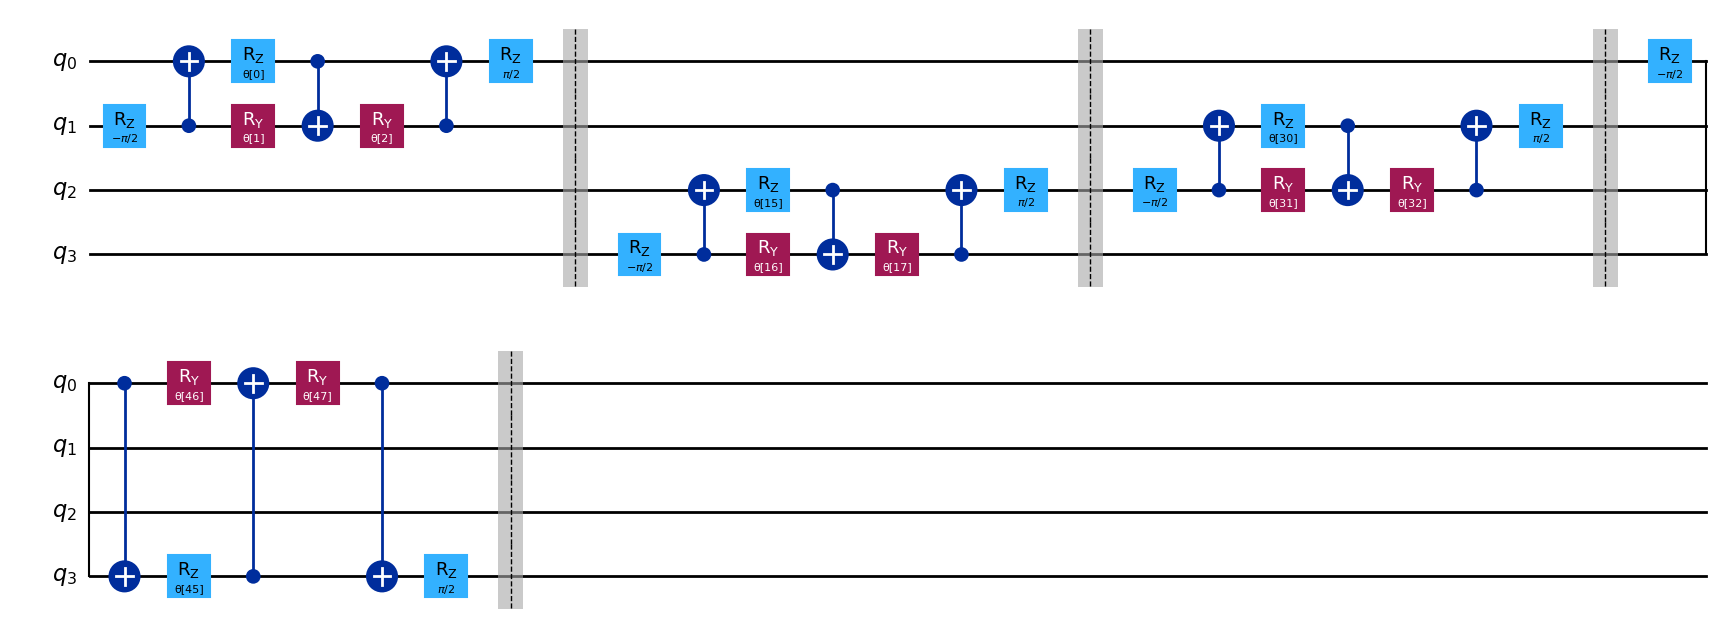

In [57]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

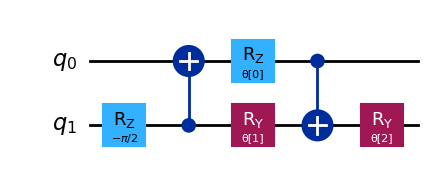

In [58]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

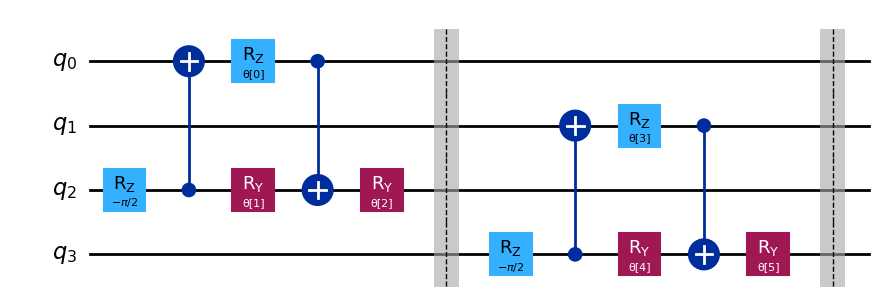

In [59]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [60]:
import tensorflow as tf
import collections
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [61]:
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [62]:
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


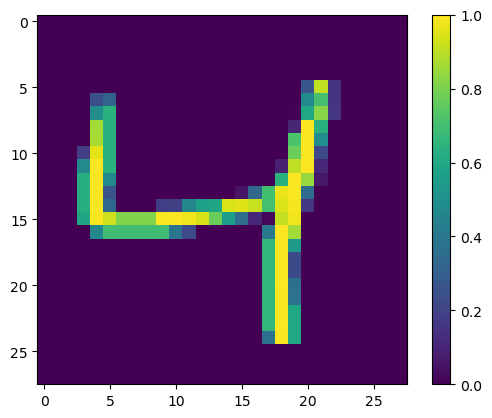

In [63]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [64]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

4


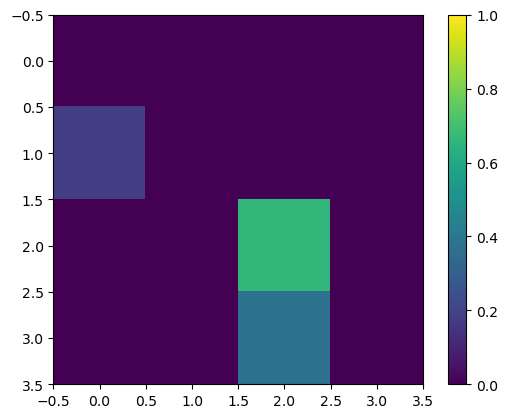

In [65]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [66]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
   
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass


    num_uniq_a = sum(1 for value in mapping.values() if len(value) == 1 and a in value)
    num_uniq_b = sum(1 for value in mapping.values() if len(value) == 1 and b in value)
    # num_uniq_c = sum(1 for value in mapping.values() if len(value) == 1 and c in value)
    num_uniq_all = sum(1 for value in mapping.values() if len(value) >= 2)


    print("Number of unique images:", len(mapping.values()))
    print("Number of unique ", a, "'s: ", num_uniq_a)
    print("Number of unique ", b, "'s: ", num_uniq_b)
    # print("Number of unique ", c, "'s: ", num_uniq_c)
    print("Number of unique contradicting labels: ", num_uniq_all)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
   
    return np.asarray(new_x), np.asarray(new_y)

In [67]:
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 10254
Number of unique  3 's:  4798
Number of unique  4 's:  5293
Number of unique contradicting labels:  163

Initial number of images:  11973
Remaining non-contradicting unique images:  10091
Number of unique images: 1833
Number of unique  3 's:  869
Number of unique  4 's:  952
Number of unique contradicting labels:  12

Initial number of images:  1992
Remaining non-contradicting unique images:  1821


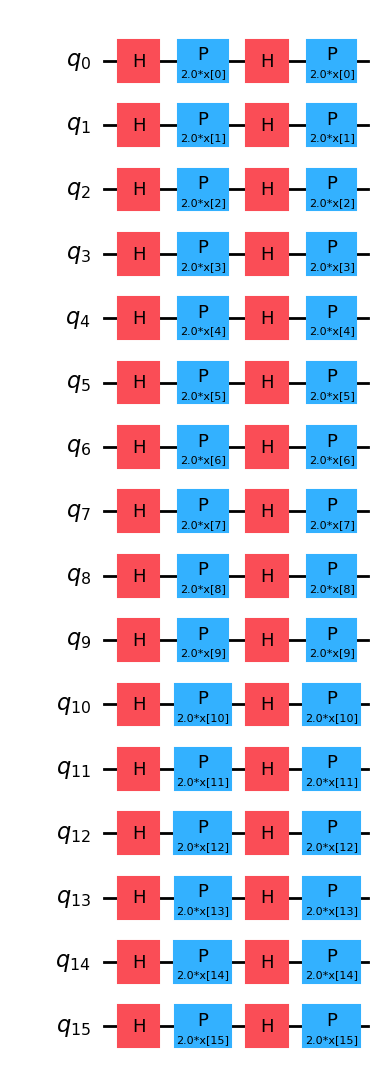

In [68]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

In [69]:
feature_map = ZFeatureMap(16)
ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# # Fourth Convolutional Layer
# ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# # Fourth Pooling Layer
# ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

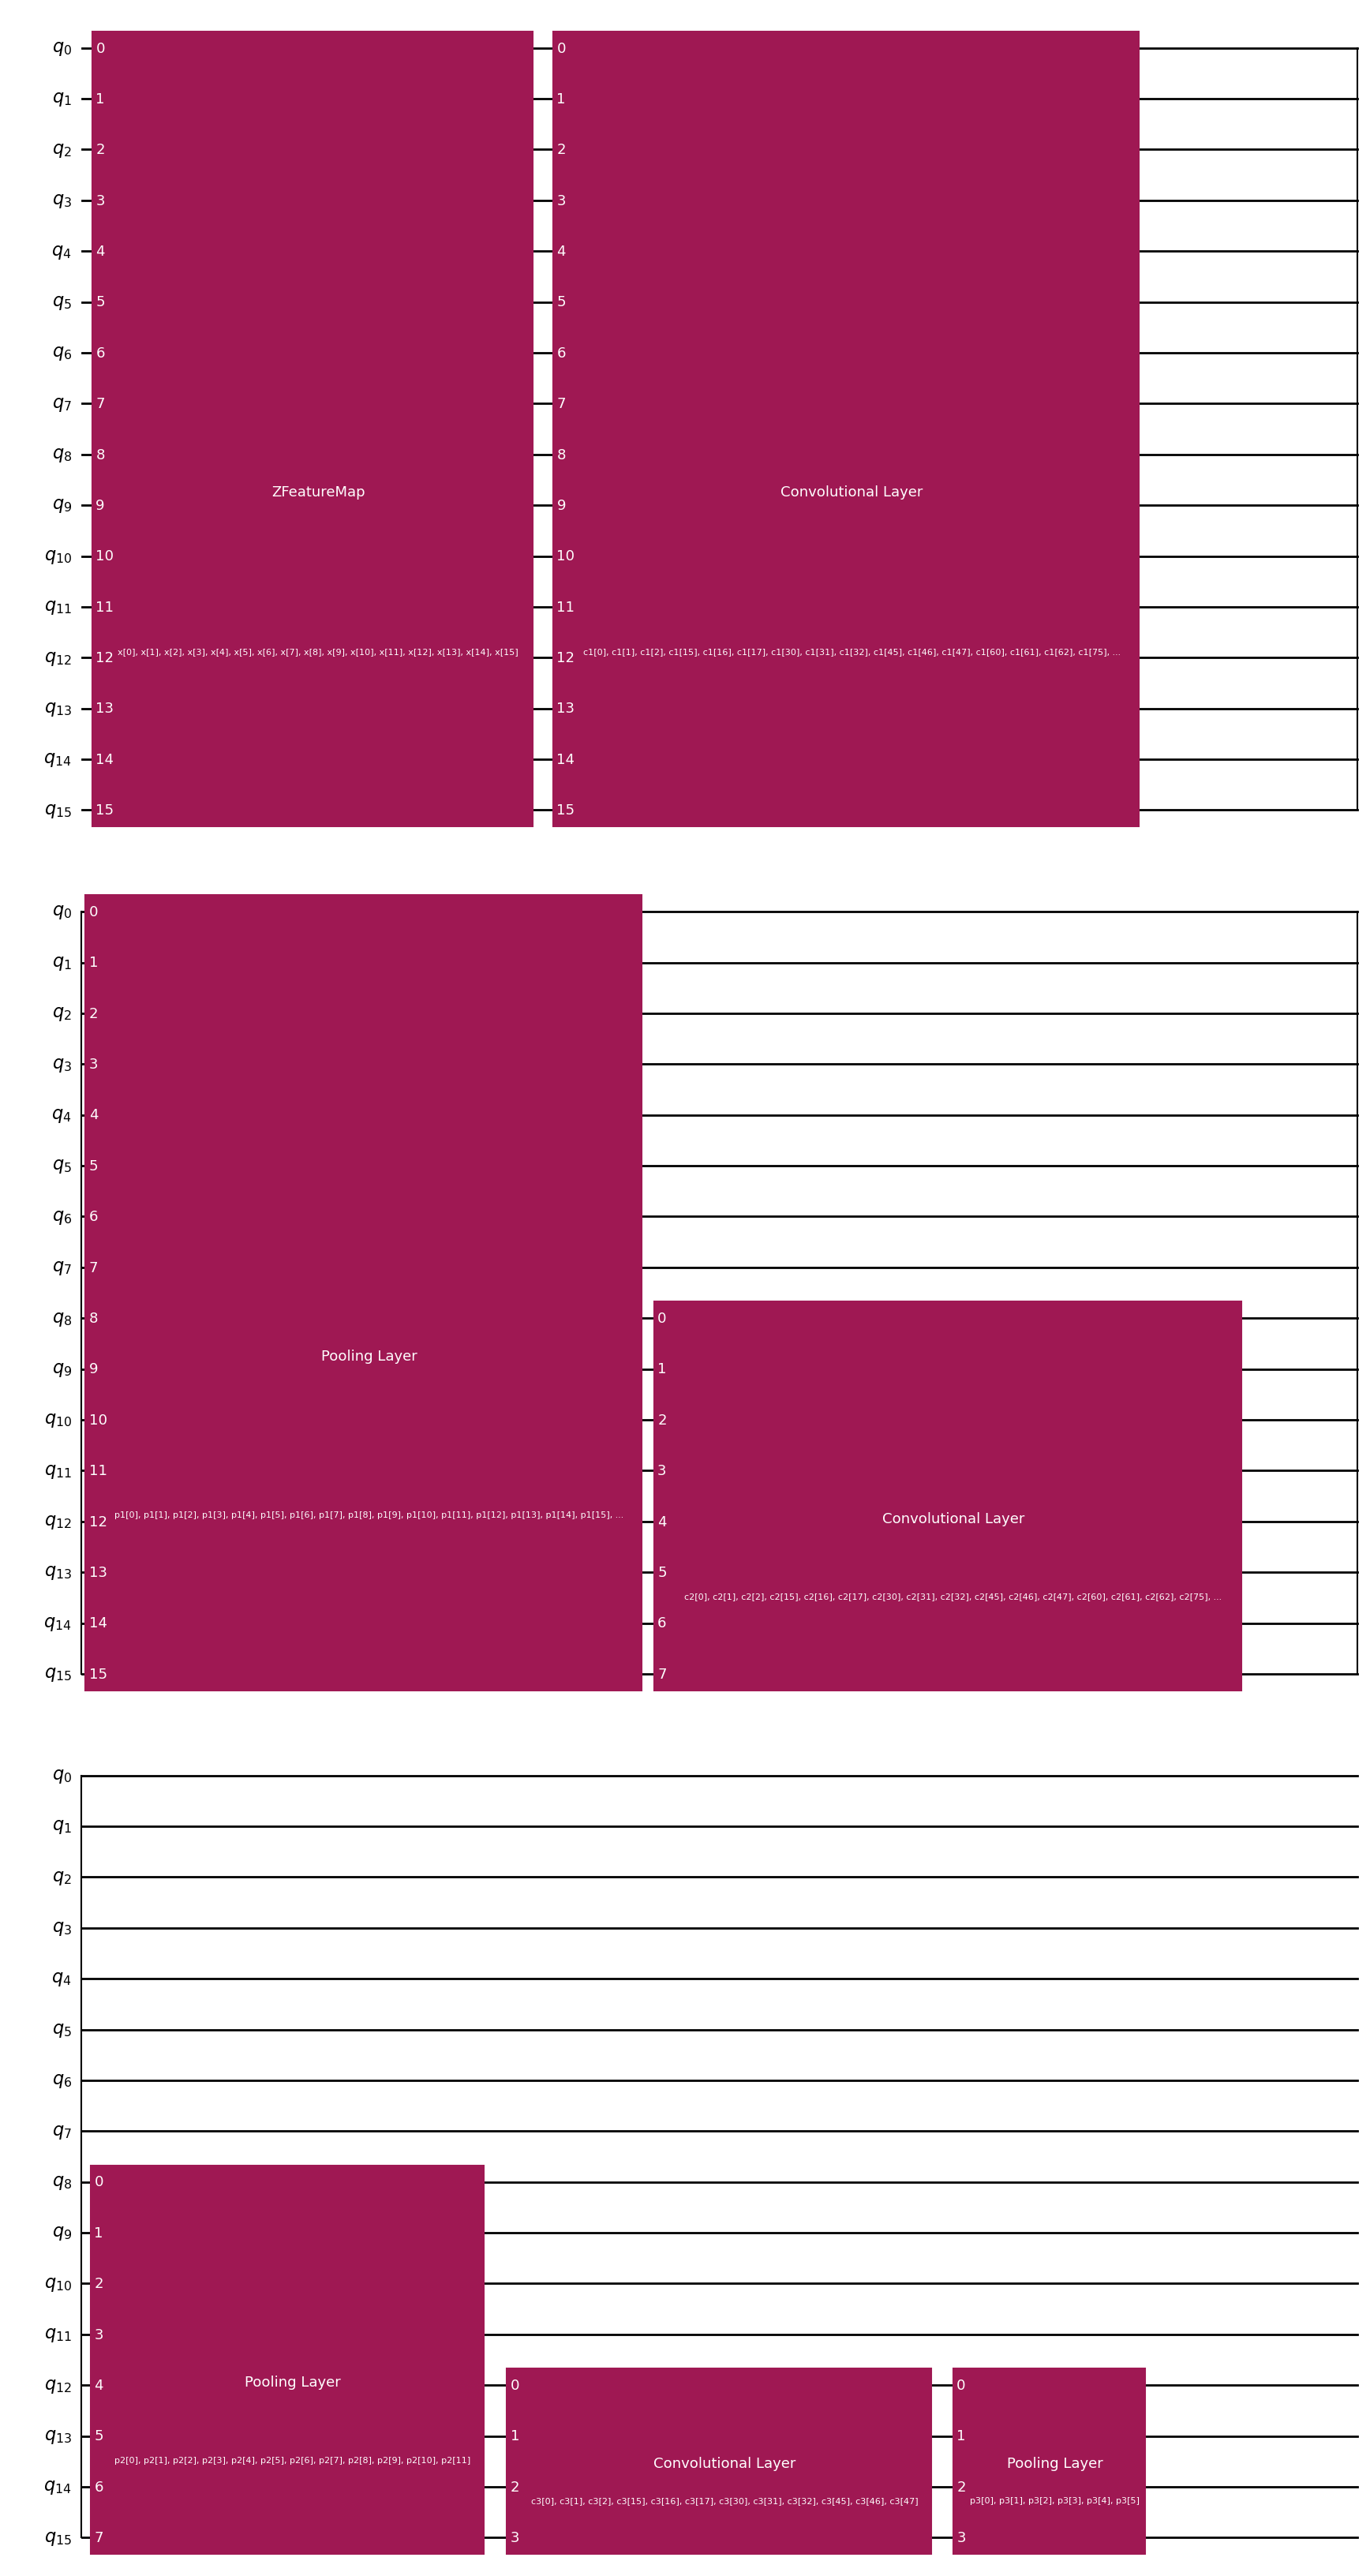

In [70]:
circuit.draw("mpl")

In [71]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    
  
    print("weights", weights)
    print("objective function value", objective_func_vals)
    
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [72]:
classifier = VQC(
    feature_map=feature_map.decompose(),
    ansatz=ansatz.decompose(),
    optimizer=COBYLA(maxiter=3),
    callback=callback_graph,
    warm_start = True,
    
)

In [75]:
x_reshaped = []
x1_reshaped = []

for b in resized_train_images:
    x_reshaped.append(b.reshape(1,16))

for b in resized_test_images:
    x1_reshaped.append(b.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    final_x.append(entry[0])

for entry in x1_reshaped:
    final_x1.append(entry[0])

objective_func_vals = []

x = np.asarray(final_x)
y = np.asarray(train_labels)

x = x[:3]
y = y[:3]

print(x)
print(y)

[[0.         0.         0.         0.         0.18039216 0.
  0.         0.         0.         0.         0.6627451  0.
  0.         0.         0.3764706  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.33333334 0.         0.         0.         0.9882353  0.
  0.         0.6745098  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.19215687 0.         0.         0.         0.01568628 0.
  0.         0.6039216  0.19215687 0.        ]]
[4 3 3]


weights [1.33040181 1.44240079 0.50230879 0.81366964 0.63303564 0.2163276
 0.42319111 0.89813077 0.09414261 0.49008768 0.63209206 0.66021285
 0.95676148 0.6220413  0.98729536 0.01658425 0.15822273 0.73121475
 0.48317597 0.95307929 0.30961317 0.07658988 0.09102999 0.58643122
 0.48083097 0.64143014 0.94985383 0.61883739 0.6222994  0.66647519
 0.54144948 0.2949166  0.56373064 0.50604344 0.18501208 0.27658524
 0.56231458 0.66624831 0.22089128 0.9844573  0.96010612 0.91648445
 0.67136926 0.82699126 0.90700739 0.39185408 0.9621142  0.4818793
 0.03458963 0.04930364 0.0972683  0.54081491 0.2941128  0.43956091
 0.06707608 0.68919974 0.89279    0.03213246 0.84769303 0.12721374
 0.77502041 0.31437666 0.8634655  0.69080011 0.73581738 0.18048366
 0.62368498 0.20891996 0.8735499  0.50491231 0.0138236  0.21857574
 0.90001764 0.46088293 0.03551781 0.71877596 0.8386519  0.34218295
 0.21554652 0.73888842 0.77379844 0.15306612 0.39125099 0.75924518
 0.03386219 0.81953885 0.52660852 0.58475177 0.41041251 

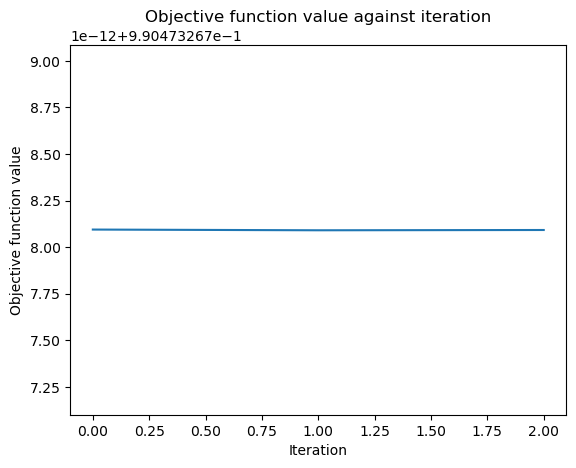

Accuracy from the train data : 33.33%


In [76]:
classifier.fit(x, y)
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [49]:
x1 = np.asarray(final_x1)
y1 = np.asarray(test_labels)
        
x1 = x1[:3]
y1 = y1[:3]
y_predict = classifier.predict(x1)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

Accuracy from the test data : 33.33%


IndexError: index 3 is out of bounds for axis 0 with size 3

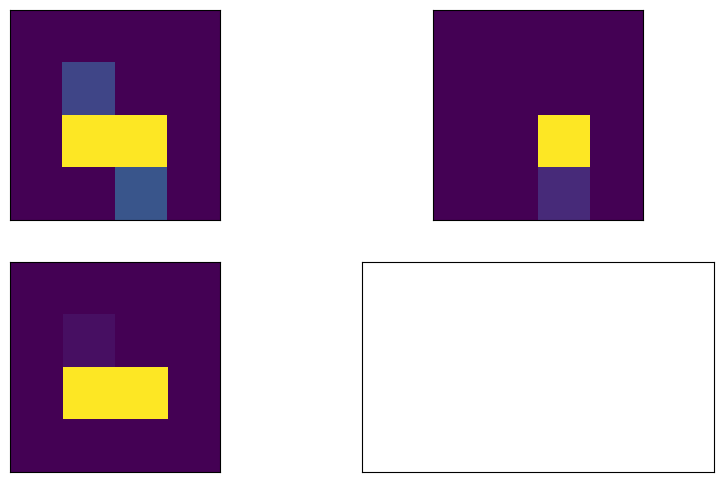

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 1")
    if y_predict[i] == 2:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 2")
    if y_predict[i] == 4:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")   
    # if y_predict[i] == 9:
    #     ax[i // 2, i % 2].set_title("The QCNN predicts this 9") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [51]:
y_predict

array([5, 3, 5], dtype=uint8)

In [52]:
classifier.weights

array([1.31009485e+00, 1.22322687e+00, 9.00338630e-01, 2.46725737e-01,
       8.73440833e-01, 2.49941272e-01, 2.29749356e-01, 3.77936312e-01,
       5.63835867e-02, 2.19151032e-02, 5.37847008e-01, 7.60766663e-01,
       4.15044927e-01, 7.21186979e-01, 4.25211996e-01, 4.41492505e-01,
       7.35928614e-01, 8.42840650e-02, 3.08833681e-01, 3.80316884e-01,
       4.77454008e-01, 7.66639699e-01, 7.39105828e-01, 6.40209123e-01,
       9.90504019e-01, 5.48515916e-01, 3.57757136e-01, 9.99641633e-01,
       5.80691995e-04, 6.49775278e-01, 5.07110458e-02, 5.72290039e-02,
       8.15567812e-01, 9.87385013e-01, 4.92779495e-01, 3.13960736e-01,
       9.71978159e-01, 6.09639286e-02, 1.38305793e-01, 5.65748520e-02,
       7.51397011e-01, 7.79088926e-01, 6.32508445e-01, 3.29482530e-01,
       4.59507852e-03, 6.89996450e-01, 8.78813537e-01, 6.94944574e-01,
       7.17914989e-02, 7.77370323e-01, 8.06688090e-01, 4.99035882e-01,
       1.04664655e-01, 6.27491931e-01, 8.77949227e-01, 6.41686389e-01,
      

In [53]:
classifier.fit_result.fun

1.5800682358166096

In [ ]:
classifier.save("bin_sampler.model")